In [1]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import tensorflow_datasets as tfds

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

# from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

import pdb
import copy

In [2]:
with open('/kaggle/input/shak-new-input/pre-train.txt', 'r', encoding='utf-8') as f:
    pre_text_train = f.read()

with open('/kaggle/input/shak-new-input/train.txt.txt', 'r', encoding='utf-8') as f:
    text_train = f.read()
    
with open('/kaggle/input/shak-new-input/test.txt', 'r', encoding='utf-8') as f:
    text_validation = f.read()

In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text_train+text_validation)))
# chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !&',-.:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
63


In [4]:
print(sorted(list(set(pre_text_train))))
len(sorted(list(set(pre_text_train))))

['\n', ' ', '!', "'", ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


60

In [5]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[44, 45, 45, 1, 56, 44, 41, 54, 41]
hii there


In [6]:
train_data = jnp.array(encode(text_train), dtype=jnp.int32)
test_data = jnp.array(encode(text_validation), dtype=jnp.int32)
pre_train_data = jnp.array(encode(pre_text_train), dtype=jnp.int32)
block_size = 8
train_data[:block_size+1]

Array([16, 45, 54, 55, 56,  1, 13, 45, 56], dtype=int32)

In [7]:
del pre_text_train
del text_train
del text_validation

In [8]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [16] the target: 45
when input is [16 45] the target: 54
when input is [16 45 54] the target: 55
when input is [16 45 54 55] the target: 56
when input is [16 45 54 55 56] the target: 1
when input is [16 45 54 55 56  1] the target: 13
when input is [16 45 54 55 56  1 13] the target: 45
when input is [16 45 54 55 56  1 13 45] the target: 56


In [9]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 16 # what is the maximum context length for predictions?
seq_size = block_size
min_seq_length=16
max_seq_length=128

num_layers = 6

max_iters = 50000
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
mamba_n_embd = 128
expans = 2
emb_features = mamba_n_embd * expans
s6_n_embd = mamba_n_embd * expans
n_filters = 4
n_conv = 3
hidden_dim = (2**(n_conv-1))*s6_n_embd*n_filters
conv_k_size = 3
n_latent_dim = 32
n_tokens = 1

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))
# rng_key, keyz = jax.random.split(jax.random.PRNGKey(1564))
# seq_size = int(jax.random.randint(keyz, shape=(1,), minval=16, maxval=128)[0])
@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - seq_length
    )
    x = dynamic_slice_vmap(data, ix, (seq_length,))
    y = dynamic_slice_vmap(data, ix + seq_length, (1,))
    return x, y
rng_key, keyz = jax.random.split(jax.random.PRNGKey(1564))
seq_length = int(jax.random.randint(keyz, shape=(), minval=min_seq_length, maxval=max_seq_length+1))
print(seq_length)
xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb.T)

19
inputs:
(64, 19)
[[37 54 41 ... 51 54 43]
 [51 56 45 ... 56 55  1]
 [ 1 49 37 ... 45 54 10]
 ...
 [ 5  1 56 ...  1 38 41]
 [41 50 39 ... 44 41  1]
 [ 1 50 51 ...  0 39 51]]
targets:
(64, 1)
[[41 61  0 41 41 41 42 54 48 44  1 38 51  0 39 54 45 39  1 44 56 48 58 51
  45 50  1 43 41  1 51 37 46 40 41 37  7 11 40 45 41 50 37 54 39 55 37 57
  39 55 42 50 56 44 42 54  6 41 41 41  1  1 51 57]]


In [10]:
# sdffsdfsdf

In [11]:
class Down_Conv(nn.Module):
    features: int = 256
    kernel_size: int = 2
    padding: str = 'CAUSAL'
    
    @nn.compact
    def __call__(self, x):
        
        conv1 = jax.nn.silu(nn.Conv(features=self.features, kernel_size=self.kernel_size, padding=self.padding)(x))
#         max_pool1 = nn.max_pool(conv1 , window_shape=(self.kernel_size,), strides=(1,), padding='same')
#         max_pool1_ind = (conv1 == jnp.repeat(max_pool1 , repeats=2, axis=1)).astype(jnp.int32)
        #########################################################################################################
        conv2 = jax.nn.silu(nn.Conv(features=self.features*2, kernel_size=self.kernel_size, padding=self.padding)(conv1))
#         max_pool2 = nn.max_pool(conv2 , window_shape=(self.kernel_size,), strides=(1,), padding='same')
#         max_pool2_ind = (conv2 == jnp.repeat(max_pool2 , repeats=2, axis=1)).astype(jnp.int32)   
        #########################################################################################################
        conv3 = jax.nn.silu(nn.Conv(features=self.features*4, kernel_size=self.kernel_size, padding=self.padding)(conv2))
        max_pool3 = nn.max_pool(conv3 , window_shape=(self.kernel_size,), strides=(1,), padding='same')
#         max_pool3_ind = (conv3 == jnp.repeat(max_pool3 , repeats=2, axis=1)).astype(jnp.int32)
        ######################################################################################################### 

#         pdb.set_trace()
        return max_pool3
    

In [12]:
class S6_Unet(nn.Module):
    
    @nn.compact
    def __call__(self, x, h=0):
        # x.shape = (Ba, n_filters, seq_size, hidden_dim)
#         _, _, seq_size , hidden_dim = x.shape
        
        A = -1* self.param('A', nn.initializers.ones, (1, n_latent_dim, hidden_dim))
        B = self.param('B', nn.initializers.ones, (1, n_latent_dim, hidden_dim))
        C = self.param('C', jax.random.normal, (1, n_latent_dim, hidden_dim))
        D = self.param('D', jax.random.normal, (1, n_latent_dim, hidden_dim))
        S = -0.5* self.param('S', nn.initializers.ones, (1, n_latent_dim, hidden_dim))
        P = self.param('P', jax.random.normal, (1, n_latent_dim, hidden_dim))
        Q = self.param('Q', jax.random.normal,(1, n_latent_dim, hidden_dim))
        
        x, h = self.ssm(x, A, B, C, D, S, P, Q, h)
        return x, h
    def ssm(self, x, A, B, C, D, S, P, Q, h):    
        def compute_delta(x, state, A, B):
            # state shape: (B, N, D)
            # A shape: (N, N)
            # B shape: (N, D)

            # State update: (B, N, D) <- (B, N, D) @ (N, N)
            state_contribution = state*A #jnp.einsum('bnd,nn->bnd', state, A)
            # Input contribution: (B, N) <- (B, D) @ (D, N)
            input_contribution = jnp.einsum('bd,1nd->bnd', x, B)

            return state_contribution + input_contribution

#         def compute_selective_mask(x, state, S, P, Q):
#             # x shape: (B, D) where B is the batch size
#             # state shape: (B, N, D)
#             # S shape: (N, D)
#             # P shape: (D, D)
#             # Q shape: (D, N)

#             # Project input
#             # (B, N) <- (B, D) @ (D, N)
#             x_proj = jnp.einsum('bd,1nd->bnd',x,S)

#             # Project state
#             # (B, N, D) < <- (B, N, D) @ (D, D)
#             state_proj = state * P

#             # Combine projections (element-wise multiplication with broadcasting)
#             # (B, N, D) <- (B, N, 1) * (B, N, D)
#             combined = x_proj + state_proj

#             # Apply non-linearity (e.g., ReLU)
#             activated = jax.nn.relu(combined)
# #             pdb.set_trace()

#             # Project to output logits
#             # (B, N, D) <- (B, N, D) @ (D, N)
# #             logits = jnp.einsum('bnd,nd->bnd', activated, Q)
#             mask = activated

#             return mask        

        for k in range(x.shape[-2]):
            # Compute ∆, the state update candidates
            delta = compute_delta(x[:, k, :], h, A, B)
#             # Compute selective mask
#             mask = compute_selective_mask(x[:, k, :], state, S, P, Q)
#             # Update state selectively
#             state += delta*mask
            h += delta*jax.nn.relu(jnp.einsum('bd,1nd->bnd',x[:, k, :],S))
    


        y = jnp.einsum('bnd,1nd->b1d', h, C) + jnp.einsum('1nd,bd->b1d', D, x[:, -1, :])
#         pdb.set_trace()
        return y, h

        

In [13]:
class FeedForward(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = jax.nn.silu(nn.Dense(hidden_dim*4)(x))
        x = jax.nn.silu(nn.Dense(hidden_dim*2)(x))
        x = jax.nn.silu(nn.Dense(hidden_dim)(x))
        return x

In [14]:
stato = jax.random.normal(jax.random.PRNGKey(654), (4,6))
asr = jax.random.normal(jax.random.PRNGKey(84), (3,6))
eins = jnp.einsum('bd,nd->bn', stato, asr)
dirbroad = stato@asr.T#(jnp.expand_dims(stato, axis=1)*asr)
print(eins.shape, dirbroad.shape)
print(jnp.allclose(eins,dirbroad))
print(eins==dirbroad)

(4, 3) (4, 3)
True
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [15]:
class LLM_Model(nn.Module):
    
    @nn.compact
    def __call__(self, x, h=0):
        embeds = nn.Embed(vocab_size, mamba_n_embd)(x)# + nn.Embed(seq_size, mamba_n_embd)(jnp.arange(seq_size))

    #         ssm_unet = S6_Unet()

 
        kernel_size = 2
        x = Down_Conv(features=s6_n_embd, kernel_size=kernel_size)(nn.RMSNorm()(embeds))
        for _ in range(n_filters-1):
            kernel_size *= 2
            x = jnp.dstack([x, Down_Conv(features=s6_n_embd, kernel_size=kernel_size)(nn.RMSNorm()(embeds))])
#         for _ in range(num_layers):
        x, h_out = S6_Unet()(jax.nn.silu(nn.RMSNorm()(x)), h)
#             pdb.set_trace()

#         x = x + FeedForward()(nn.RMSNorm()(x))

        x = nn.Dense(mamba_n_embd)(nn.RMSNorm()(x))

#         x = nn.Dense(vocab_size)(nn.RMSNorm()(jnp.expand_dims(x[:,-1,:], axis=1)))
        x = nn.Dense(vocab_size)(nn.RMSNorm()(x))

        return x, h_out

In [16]:
def loss_fun(params, x, y):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

@jax.jit
def eval_step(params, x, y):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [17]:
key = jax.random.PRNGKey(42)
# x = jnp.expand_dims(xb[0],axis=0)
x = xb

model = LLM_Model()

params = model.init(jax.random.PRNGKey(45),x)
print(params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(params))

print(f"Total number of parameters: {n_params:_}")

output, h = model.apply(params, x)
print(output.shape, h.shape)

dict_keys(['params'])
Total number of parameters: 22_117_951
(64, 1, 63) (64, 32, 4096)


In [56]:
@partial(jax.jit, static_argnames=("length"))
def generate_text(rng, params, length, start_text):
#     _, h = model.apply(params, start_text)
    def _scan_generate(carry, _):
        random_key, context = carry
        logits, h = model.apply(params, context)
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits, axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context, new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, start_text),
    (),
    length=length,
    )
    return new_tokens

In [53]:
# @partial(jax.jit, static_argnames=("length"))
# def generate_text(rng, params, length, start_text):
#     _, h = model.apply(params, start_text)
#     def _scan_generate(carry, _):
#         random_key, context, h = carry
#         logits, h = model.apply(params, context, h)
#         rng, rng_subkey = jax.random.split(random_key)
#         new_token = jax.random.categorical(
#           rng_subkey, logits, axis=-1, shape=(1, 1)
#         )
# #         context = jnp.expand_dims(new_token, axis=(0,1))
#         return (rng, new_token, h), new_token

#     _, new_tokens = jax.lax.scan(
#     _scan_generate,
#     (rng, jnp.expand_dims(start_text[:,-1], axis=0), h),
#     (),
#     length=length,
#     )
#     return new_tokens

In [31]:
new_tokenz = 1000
i = 916
start_text = test_data[i-block_size:i]
key, subkey = jax.random.split(jax.random.PRNGKey(927))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, params, new_tokenz, jnp.expand_dims(start_text, axis=0))[:, 0, 0].tolist()
print(token_gen)
print('\n')
print(decode(start_text.tolist()+token_gen))

> /tmp/ipykernel_629/2444105220.py(8)_scan_generate()
      6         logits, h = model.apply(params, context, h)
      7         pdb.set_trace()
----> 8         rng, rng_subkey = jax.random.split(random_key)
      9         new_token = jax.random.categorical(
     10           rng_subkey, logits, axis=-1, shape=(1, 1)



ipdb>  cont


[61, 54, 58, 54, 36, 8, 39, 23, 2, 44, 36, 58, 38, 10, 26, 47, 52, 50, 24, 55, 10, 60, 20, 35, 0, 57, 9, 21, 62, 10, 18, 36, 52, 13, 26, 59, 39, 50, 45, 29, 1, 46, 52, 39, 33, 12, 58, 36, 52, 38, 44, 54, 30, 8, 27, 57, 14, 26, 57, 60, 10, 19, 47, 15, 52, 45, 49, 7, 47, 8, 52, 37, 31, 8, 30, 36, 28, 1, 22, 59, 14, 55, 26, 15, 58, 39, 21, 30, 35, 47, 60, 34, 62, 35, 0, 57, 50, 7, 27, 48, 34, 5, 57, 46, 46, 5, 44, 19, 1, 2, 6, 16, 36, 36, 16, 36, 35, 35, 44, 36, 15, 17, 5, 25, 62, 21, 54, 21, 36, 10, 34, 7, 21, 55, 38, 58, 13, 15, 25, 52, 62, 33, 3, 48, 38, 31, 52, 31, 49, 59, 3, 58, 0, 29, 15, 59, 12, 43, 8, 61, 19, 52, 11, 43, 0, 7, 5, 52, 30, 30, 2, 12, 36, 50, 26, 53, 48, 58, 19, 5, 21, 53, 36, 48, 30, 55, 39, 52, 54, 30, 60, 45, 45, 6, 54, 6, 54, 6, 45, 55, 37, 23, 33, 1, 43, 17, 27, 21, 52, 6, 26, 61, 52, 5, 52, 14, 22, 4, 47, 39, 52, 25, 43, 49, 26, 2, 2, 29, 44, 53, 1, 51, 61, 47, 2, 44, 44, 44, 44, 10, 60, 34, 38, 47, 44, 58, 54, 38, 32, 17, 9, 49, 45, 38, 50, 60, 2, 2, 57, 16, 3

In [32]:
# sdfgdfgdg

In [33]:
# lr_schedule  = optax.linear_schedule(init_value=learning_rate,end_value=learning_rate/10,transition_steps=eval_iters)

opt = optax.adamw(learning_rate=learning_rate)

opt_state = opt.init(params)

In [34]:
# %%time

# all_train_losses = []
# all_eval_losses = []

# all_train_accuracy =  []
# all_test_accuracy = []

# base_loss = 10.2

# # we define one iteration of the optimizer and JIT this function
# @jax.jit
# def step(key, params, opt_state):
#     key, subkey = jax.random.split(key)
#     xb, yb = get_batch(key, pre_train_data)
#     (loss, train_accuracy), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb)
#     updates, opt_state = opt.update(grad, opt_state, params)
#     params = optax.apply_updates(params, updates)
#     return params, key, opt_state, loss, train_accuracy

# # for i in tqdm(range(max_iters)):
# counter = 0
# while counter<5000:

#     params, key, opt_state, loss, train_accuracy = step(key, params, opt_state)
    
# #     if loss<base_loss:
# #         base_loss = loss
# #         new_params = copy.deepcopy(params)

#     # once every N_FREQ_EVAL we compute loss on the validation set
#     if counter % eval_iters == 0:
# #         key, subkey = jax.random.split(key)
# #         eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data))
#         all_train_losses.append(loss)
# #         all_eval_losses.append(eval_loss)
#         all_train_accuracy.append(train_accuracy)
# #         all_test_accuracy.append(eval_accuracy)
#         print('####################################################################################################')
#         print("Step: ", counter,"\t\t Train Loss: ", format(loss, ".6f"),"\t\t Train Accuracy: ", format(train_accuracy, ".2%"))
# #         print("Step: ", counter,"\t\t Eval Loss: ", format(eval_loss, ".6f"),"\t\t Eval Accuracy: ", format(eval_accuracy, ".2%"))
        
#     counter += 1
        

In [35]:
%%time

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

base_loss = 10.2

# we define one iteration of the optimizer and JIT this function
@jax.jit
def step(key, params, opt_state):
    key, subkey = jax.random.split(key)
    xb, yb = get_batch(key, train_data)
    (loss, train_accuracy), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, key, subkey, opt_state, loss, train_accuracy

# for i in tqdm(range(max_iters)):
counter = 0
while counter<max_iters:
    
    params, key, subkey, opt_state, loss, train_accuracy = step(key, params, opt_state)
    seq_length = int(jax.random.randint(subkey, shape=(), minval=min_seq_length, maxval=max_seq_length+1))
    if loss<base_loss:
        base_loss = loss
        new_params = copy.deepcopy(params)

    # once every N_FREQ_EVAL we compute loss on the validation set
    if counter % eval_iters == 0:
        key, subkey = jax.random.split(key)
        eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data))
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print('####################################### Sequence Length = ', seq_length, '#############################################################')
        print("Step: ", counter,"\t\t Train Loss: ", format(loss, ".6f"),"\t\t Train Accuracy: ", format(train_accuracy, ".2%"))
        print("Step: ", counter,"\t\t Eval Loss: ", format(eval_loss, ".6f"),"\t\t Eval Accuracy: ", format(eval_accuracy, ".2%"))
        
    counter += 1

####################################### Sequence Length =  63 #############################################################
Step:  0 		 Train Loss:  4.582474 		 Train Accuracy:  1.56%
Step:  0 		 Eval Loss:  4.636768 		 Eval Accuracy:  14.06%
####################################### Sequence Length =  63 #############################################################
Step:  100 		 Train Loss:  3.068756 		 Train Accuracy:  23.44%
Step:  100 		 Eval Loss:  2.876528 		 Eval Accuracy:  25.00%
####################################### Sequence Length =  74 #############################################################
Step:  200 		 Train Loss:  2.733462 		 Train Accuracy:  28.12%
Step:  200 		 Eval Loss:  2.937849 		 Eval Accuracy:  12.50%
####################################### Sequence Length =  94 #############################################################
Step:  300 		 Train Loss:  2.224625 		 Train Accuracy:  31.25%
Step:  300 		 Eval Loss:  2.282477 		 Eval Accuracy:  39.06%
#############

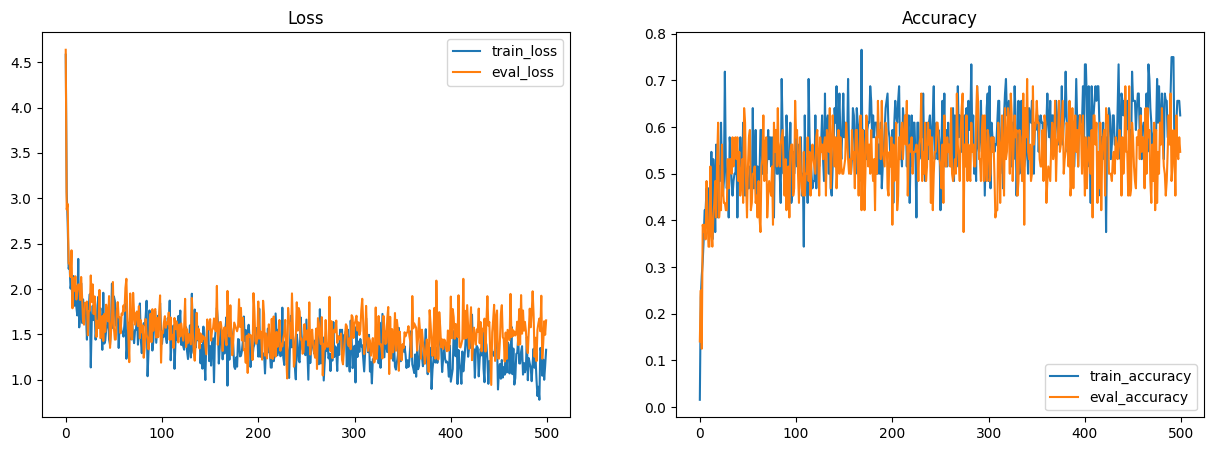

<Figure size 640x480 with 0 Axes>

In [36]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [37]:
test_data[892:892+block_size]

Array([22, 45, 39, 45, 51,  5,  1, 38, 51, 54, 50,  1, 45, 50,  1, 23],      dtype=int32)

In [38]:
i = 916
decode(test_data[i-block_size*10:i].tolist())

'atics,\nTo instruct her fully in those sciences,\nWhereof I know she is not ignorant:\nAccept of him, or else you do me wrong:\nHis name is Licio, born in Mantua.\n\n'

In [57]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(87))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
first_token_gen = generate_text(key, params, new_tokenz, jnp.expand_dims(test_data[i-block_size*10:i], axis=0))[:, 0, 0].tolist()
print(first_token_gen)
print('\n')
print(decode(start_text.tolist()+first_token_gen))

TypeError: Scanned function carry input and carry output must have equal types (e.g. shapes and dtypes of arrays), but they differ:
  * the input carry component carry[1] has type int32[1,160] but the corresponding output carry component has type int32[1,161], so the shapes do not match

Revise the scanned function so that all output types (e.g. shapes and dtypes) match the corresponding input types.

In [55]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(927))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
second_token_gen = generate_text(key, new_params, new_tokenz, jnp.expand_dims(test_data[i-block_size*10:i], axis=0))[:, 0, 0].tolist()
print(second_token_gen)
print('\n')
print(decode(start_text.tolist()+second_token_gen))

[12, 28, 11, 21, 15, 24, 12, 31, 28, 35, 8, 0, 26, 37, 54, 40, 51, 50, 1, 55, 56, 54, 51, 47, 41, 55, 9, 1, 4, 56, 45, 55, 1, 49, 61, 1, 39, 37, 50, 1, 52, 41, 54, 39, 41, 45, 58, 41, 0, 38, 41, 56, 59, 51, 57, 50, 40, 1, 57, 55, 41, 1, 37, 59, 37, 61, 7, 1, 18, 41, 37, 58, 41, 50, 1, 49, 51, 1, 41, 61, 41, 55, 2, 0, 0, 29, 41, 54, 58, 37, 50, 56, 8, 0, 22, 57, 50, 5, 1, 56, 51, 1, 49, 37, 47, 41, 1, 51, 1, 49, 37, 50, 1, 51, 50, 48, 61, 1, 44, 41, 54, 41, 5, 0, 30, 51, 1, 48, 37, 61, 1, 56, 44, 41, 49, 1, 37, 50, 40, 1, 44, 45, 55, 1, 38, 57, 56, 39, 44, 41, 54, 4, 0, 29, 37, 42, 41, 1, 51, 54, 1, 52, 48, 37, 45, 50, 5, 1, 30, 54, 37, 50, 45, 51, 1, 61, 51, 57, 5, 0, 30, 44, 37, 56, 1, 55, 51, 49, 41, 1, 55, 45, 45, 48, 1, 45, 50, 1, 45, 55, 1, 50, 51, 1, 43, 45, 56, 41, 40, 1, 49, 61, 1, 44, 51, 50, 51, 57, 54, 5, 1, 37, 50, 40, 1, 48, 45, 47, 41, 1, 56, 51, 1, 40, 41, 39, 44, 41, 54, 61, 7, 0, 0, 27, 31, 15, 15, 24, 1, 23, 11, 28, 17, 11, 28, 15, 30, 8, 0, 16, 51, 54, 1, 40, 37, 57,

In [ ]:
jax.random.randint(
      key, shape=(1,), minval=16, maxval=128
    ).astype(jnp.int32)

In [ ]:
base_loss

In [ ]:
decode(start_text.tolist())

In [ ]:
params['params']['Embed_1']['embedding'].shape

In [ ]:
params['params']['S6_Unet_0']['A'][:,:,100,:].shape

In [ ]:
var_params = copy.deepcopy(params)

In [ ]:
with open('/kaggle/input/shak-new-input/pre-train.txt', 'r', encoding='utf-8') as f:
    pre_text_train = f.read()



In [ ]:
pre_text_train[0:50]

In [ ]:
pre_text_train_mod = pre_text_train.replace(",\n"," ").replace(","," ").replace("\n"," ").replace("!"," ").replace("?"," ").replace(";"," ")
pre_words = pre_text_train_mod.split(" ")
for word in pre_words[0:50]:
    print(word)


In [ ]:
pre_words[0:50]